In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time 

In [ ]:
# new
class FFL():
    """
        A class to create a single input/hidden feedforward layer of given shape.
        
        Input:
        -------
        n_input: Number of input values to layer. If none, tried to check from preious layer.
        neurons: Neurons on that layer.
        bias: External bias numpy array. If None, used from np.random.randn(neurons)
        weights: External weight numpy array. If None, used from np.random.randn(n_input, neurons)
        activation: One of ["relu", "sigmoid", "tanh", "softmax"].
        is_bias: Do we want bias to be used here? Default True.
        
        Output:
        --------
        Object of FFL which can be stacked later to use.
        
        Example:
        FFL(2, 2, activation="sigmoid")
    """
    
    def __init__(self, input_shape=None, neurons=1, bias=None, weights=None, activation=None, is_bias = True):
        
        np.random.seed(100)
        self.input_shape = input_shape
        self.neurons = neurons
        self.isbias = is_bias
        self.name = ""
        
        
        
        if input_shape != None:
            self.output_shape = neurons
        
        
        if self.input_shape != None:
            self.weights = weights if weights != None else np.random.randn(self.input_shape, neurons)
            self.parameters = self.input_shape *  self.neurons + self.neurons if self.isbias else 0  
        if(is_bias):
            self.biases = bias if bias != None else np.random.randn(neurons)
        else:
            self.biases = 0
            
        self.out = None
        self.input = None
        self.error = None
        self.delta = None
        activations = ["relu", "sigmoid", "tanh", "softmax"]
        self.delta_weights = 0
        self.delta_biases = 0
        self.pdelta_weights = 0
        self.pdelta_biases = 0
        
        #self.bias = np.ones(self.bias.shape)
        
        if activation not in activations and activation != None:
             raise ValueError(f"Activation function not recognised. Use one of {activations} instead.")
        else:
            self.activation = activation
            
           
    def activation_dfn(self, r):
        """
            A method of FFL to find derivative of given activation function.
        """
        
        
        if self.activation is None:
            return np.ones(r.shape)

        if self.activation == 'tanh':
            return 1 - r ** 2

        if self.activation == 'sigmoid':
            return r * (1 - r)

        if self.activation == "softmax":
            soft = self.activation_fn(r)
                    
            #s = soft.reshape(-1, 1)
            #dsoft = np.diagflat(s) - np.dot(s, s.T)
            #diag_soft = dsoft.diagonal()
            
            # take only the diagonal of dsoft i.e i==j only
            """
                soft = a / np.sum(a)

                dsoft = np.diag(soft)
                for i in range(len(x)):
                    for j in range(len(soft)):
                        if i == j:
                            d = 1
                        else:
                            d = 0
                        dsoft[i][j] = soft[i] * (d - soft[j])
            """
            diag_soft = soft*(1- soft)
            return diag_soft
        
        return r

    def activation_fn(self, r):
        """
        A method of FFL which contains the operation and defination of given activation function.
        """
        
        if self.activation == None or self.activation == "linear":
            return r

        # tanh
        if self.activation == 'tanh':
            return np.tanh(r)

        # sigmoid
        if self.activation == 'sigmoid':
            
            return 1 / (1 + np.exp(-r))

        if self.activation == "softmax":
            # stable softmax
            r = r - np.max(r)
            s = np.exp(r)
            return s / np.sum(s)
        
    def apply_activation(self, x):
        soma = np.dot(x, self.weights) + self.biases
        self.out = self.activation_fn(soma)
        
        return self.out
    def set_n_input(self):
        self.weights = self.w if self.w != None else np.random.normal(size=(self.n_input, self.neurons))
    def backpropagate(self, nx_layer):
        self.error = np.dot(nx_layer.weights, nx_layer.delta)
        self.delta = self.error * self.activation_dfn(self.out)
        self.delta_weights += self.delta * np.atleast_2d(self.input).T
        self.delta_biases += self.delta
    
    # added below methods from cnn
    def set_output_shape(self):
        self.set_n_input()
        self.output_shape = self.neurons
        self.get_parameters()
    def get_parameters(self):
        self.parameters = self.input_shape *  self.neurons + self.neurons if self.isbias else 0  
        return self.parameters
# new NN
class NN:
    def __init__(self):
        self.layers = []
        self.info_df = {}
        self.column = ["LName", "Input", "Output", "Activation", "Bias"]
        self.parameters = 0
        self.optimizer = ""
        self.loss = ""
        self.all_loss = {}
        self.lr = 1
        self.metrics = []
        self.av_optimizers = ["sgd", "iterative", "momentum", "rmsprop", "adagrad", "adam", "adamax", "adadelta"]
        self.av_metrics = ["mse", "accuracy", "cse"]
        self.av_loss = ["mse", "cse"]
        self.iscompiled = False
    
        self.batch_size = 8
        self.mr = 0.0001
        self.all_acc = []
        self.eps = 1e-8
    
    def add(self, layer):
        if(len(self.layers) > 0):
            prev_layer = self.layers[-1]
            if prev_layer.name != "Input Layer":
                prev_layer.name = f"Hidden Layer{len(self.layers) - 1}" 
            if layer.input_shape == None:
                layer.input_shape = prev_layer.output_shape
                layer.set_output_shape()
            layer.name = "Output Layer"
            if prev_layer.neurons != layer.input_shape and layer.input_shape != None:
                raise ValueError(f"This layer '{layer.name}' must have neurons={prev_layer.neurons} because '{prev_layer.name}' has output of {prev_layer.neurons}.")
        else:
            layer.name = "Input Layer"
        #layer.parameters = layer.n_input * layer.neurons + layer.neurons * 1 if layer.isbias else 0
        self.layers.append(layer)
        
    def summary(self):
        lname = []
        linput = []
        lneurons = []
        lactivation = []
        lisbias = []
        for layer in self.layers:
            #self.layer_info.append(f"\t|| {layer.name} \t || {layer.n_input} \t || {layer.neurons} \t|| {layer.activation} \t || {layer.isbias} ||\n") 
            lname.append(layer.name)
            linput.append(layer.input_shape)
            lneurons.append(layer.neurons)
            lactivation.append(layer.activation)
            lisbias.append(layer.isbias)
            
            self.parameters += layer.parameters
        model_dict = {"Layer Name": lname, "Input": linput, "Neurons": lneurons, "Activation": lactivation, "Bias": lisbias}    
        model_df = pd.DataFrame(model_dict).set_index("Layer Name")
        #summ = "".join(self.layer_info)
        #print(summ)
        print(model_df)
        print("Total Parameters: ", self.parameters)
    
    def visualize(self):
        k = list(self.all_loss.keys())
        v = list(self.all_loss.values())
        plt.plot(k, v)
        plt.xlabel("Epochs")
        plt.ylabel(self.loss)
        plt.show()
    
    def compile_model(self, lr=0.01, mr = 0.001, opt = "sgd", loss = "mse", metrics=['mse']):
        if opt not in self.av_optimizers:
            raise ValueError(f"Optimizer is not understood, use one of {self.av_optimizers}.")
        
        for m in metrics:
            if m not in self.av_metrics:
                raise ValueError(f"Metrics is not understood, use one of {self.av_metrics}.")
        
        if loss not in self.av_loss:
            raise ValueError(f"Loss function is not understood, use one of {self.av_loss}.")
        
        #self.optimizer = opt
        self.loss = loss
        self.lr = lr
        self.mr = mr
        self.metrics = metrics
        self.iscompiled = True
        self.optimizer = Optimizer(layers=self.layers, name=opt, learning_rate=lr, mr=mr)
        self.optimizer = self.optimizer.opt_dict[opt]
        #print(self.optimizer)
        """
            if opt == "sgd":
                self.optimizer = Optimizer(layers=self.layers, name="sgd", learning_rate=lr)
                self.optimizer = self.optimizer.sgd
            elif opt == "adam":
                self.optimizer = Optimizer(layers=self.layers, name="adam", learning_rate=lr)
                self.optimizer = self.optimizer.adam
                self.optimizer = self.ADAM
                alpha = self.lr
                beta1 = 0.9
                beta2 = 0.999
                epsilon = 1e-8
                for l in self.layers:
                    l.adam_param = []
                    # w, a, b1, b2, eps, m, v, t
                    l.adam_param = [[l.weights, alpha, beta1, beta2, epsilon, 0, 0, 0]]
                    if l.isbias:
                        l.adam_param.append([l.bias, alpha, beta1, beta2, epsilon, 0, 0, 0])
        """
    def SGD(self, update):
        for i in range(len(self.layers)):
            layer = self.layers[i]       
            #print(layer.delta.shape, layer.delta_weights.shape, layer.pdelta_biases)
            input_to_use = np.atleast_2d(layer.input)
            #dw = layer.delta * input_to_use[-1].T 
            #db =  layer.delta 
            if update:
                layer.delta_weights /= self.batch_size
                layer.delta_biases /= self.batch_size
                #print(layer.delta_weights.shape, layer.weights.shape)
                layer.weights += (layer.pdelta_weights * self.mr  + layer.delta_weights * self.lr)
                layer.biases += (layer.pdelta_biases * self.mr  +  layer.delta_biases * self.lr)
                layer.pdelta_weights = layer.delta_weights
                layer.pdelta_biases = layer.delta_biases
            #else:
                layer.delta_weights = 0
                layer.delta_biases = 0 
   
    def ADAM(self, update):
        
        for i in range(len(self.layers)):
            layer = self.layers[i]         
            input_to_use = np.atleast_2d(layer.input)
            dw = layer.delta * input_to_use.T 
            db =  layer.delta 
            dparam = [dw, db]
            nparam = []
            l = layer
            for i, grad in enumerate(dparam):
                #print(i)
                theta = l.adam_param[i][0]
                alpha = l.adam_param[i][1]
                beta1 = l.adam_param[i][2]
                beta2 = l.adam_param[i][3]
                epsilon = l.adam_param[i][4]
                m = l.adam_param[i][5]
                v = l.adam_param[i][6]
                t = l.adam_param[i][7] + 1
                             
                m = beta1 * m + (1-beta1) * grad # moving avg of grad
                v = beta2 * v + (1-beta2) * np.power(grad, 2) #
                m_cap = m / (1 - np.power(beta1, t))
                v_cap = v / (1 - np.power(beta2, t))
                theta += (self.mr * layer.dprev[i]) + (alpha * np.nan_to_num(m_cap / (np.sqrt(v_cap) + epsilon)))
                layer.dprev[i] = np.nan_to_num((m_cap / (np.sqrt(v_cap) + epsilon))) * 0
                l.adam_param[i] = [theta, alpha, beta1, beta2, epsilon, m, v, t]
                nparam.append(theta)
            if len(nparam) == 2:
                layer.weights = nparam[0]
                layer.bias = nparam[1]
            else:
                layer.weights = nparam[0]
            
    def feedforward(self, x):
        for l in self.layers:
            l.input = x
            
            x = l.apply_activation(x)  
            #print(l.name, "ip", l.input.shape, "op", x.shape)
            #print(l.weights.shape, l.bias)
            l.out = x
            
        return x
        
    def predict(self, X):
        out = []
        for x in X:
            out.append(self.feedforward(x))
        return out
#         pass
    def apply_loss(self, y, out):
        if self.loss == "mse":
            loss = y - out
            mse = np.mean(np.square(loss))
#             self.all_loss.append(mse)          
            return loss, mse
        if self.loss == 'cse':
            """ Requires out to be probability values. """     
            if len(out) == len(y) == 1:
                #print("Using Binary CSE.")
                #y += self.eps
                #out += self.eps
                cse = -(y * np.log(out) + (1 - y) * np.log(1 - out))
                loss = -(y / out - (1 - y) / (1 - out))
                #cse = np.mean(abs(cse))
            else:
                #print("Using Categorical CSE.")
                if self.layers[-1].activation == "softmax":
                    # if o/p layer's fxn is softmax then loss is y - out
                    # check the derivation of softmax and crossentropy with derivative
                    loss = y - out
                    loss = np.nan_to_num(loss / self.layers[-1].activation_dfn(out))
                else:
                    y = np.float64(y)
                    #y += self.eps
                    out += self.eps
                    #cse =  -np.sum(y * (np.log(out)))
                    
                    loss = -(np.nan_to_num(y / out) - np.nan_to_num((1 - y) / (1 - out)))
                
            
                cse = -np.sum((y * np.nan_to_num(np.log(out)) + (1 - y) * np.nan_to_num(np.log(1 - out))))
            return loss, cse
        
    def backpropagate(self, loss, update = True):
        
        
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            if layer == self.layers[-1]:
                layer.error = loss
                
                layer.delta = layer.error * layer.activation_dfn(layer.out) 
                #layer.pdelta_weights = layer.delta_weights
                #layer.pdelta_biases = layer.delta_biases

                layer.delta_weights += layer.delta * np.atleast_2d(layer.input).T
                layer.delta_biases += layer.delta

            else:
                nx_layer = self.layers[i+1]
                layer.backpropagate(nx_layer)
            if update:
                layer.delta_weights /= self.batch_size
                layer.delta_biases /= self.batch_size
        if update:
            #self.SGD(update)       
            self.optimizer(self.layers)
            self.zerograd()
    def zerograd(self):
        for l in self.layers:
            l.delta_weights=0
            l.delta_biases = 0
    def check_trainnable(self, X, Y):
        if self.iscompiled == False:
            raise ValueError("Model is not compiled.")
        if len(X) != len(Y):
            raise ValueError("Length of training input and label is not equal.")
        if X[0].shape[0] != self.layers[0].input_shape:
            layer = self.layers[0]
            raise ValueError(f"'{layer.name}' expects input of {layer.input_shape} while {X[0].shape[0]} is given.")
        if Y.shape[-1] != self.layers[-1].neurons:
            op_layer = self.layers[-1]
            raise ValueError(f"'{op_layer.name}' expects input of {op_layer.neurons} while {Y.shape[-1]} is given.")  
        
    def train(self, X, Y, epochs, show_every=1, batch_size = 32, shuffle=True):
        self.check_trainnable(X, Y)
        self.batch_size = batch_size
        t1 = time.time()
        self.losses = []
        
        len_batch = int(len(X)/batch_size)
        
        
        batches = []
        
        curr_ind = np.arange(0, len(X), dtype=np.int32)
        if shuffle: 
            np.random.shuffle(curr_ind)

        if(len(curr_ind) % batch_size) != 0 :
            nx = len(curr_ind) % batch_size
            nx = curr_ind[:nx]
            curr_ind = np.hstack([curr_ind, nx])
        #print(curr_ind.shape, len_batch)
        batches = np.split(curr_ind, batch_size)

        #print(len(batches))
        for e in range(epochs):            
            
            err = []
            for batch in batches:
                a = [] 
                curr_x, curr_y = X[batch], Y[batch]
                b = 0
                batch_loss = 0
                for x, y in zip(curr_x, curr_y):
                    out = self.feedforward(x)
                    loss, error = self.apply_loss(y, out)
                    #loss = loss.mean(axis=0)
                    batch_loss += loss
                    err.append(error)
                    update = False
                    if b == batch_size-1:
                        update = True
                        loss = batch_loss/batch_size
                    self.backpropagate(loss, update)
                    b+=1
                

            if e % show_every == 0:      
                out = self.feedforward(X)
                loss, error = self.apply_loss(Y, out)
                #print(error)
                out_activation = self.layers[-1].activation
                print(out_activation)
                if out_activation == "softmax":
                    #print(out, Y)
                    pred = out.argmax(axis=1) == Y.argmax(axis=1)
                    #loss, error = self.apply_loss(Y, out)
                elif out_activation == "sigmoid":
                    pred = out > 0.7
                    #pred = pred == Y
                elif out_activation == None:
                    pred = abs(Y-out) < 0.000001
                    
                self.all_loss[e] = loss
                a = np.array(a)
                err = np.array(err)
                print(f"Time: {round(time.time() - t1, 3)}sec")
                t1 = time.time()
                print('Epoch: #%s, Loss: %f' % (e, round(error.mean(), 4)))
                print(f"Accuracy: {round(pred.mean() * 100, 4)}%")
    

In [17]:
# this class is great (old)
class FFL():
    """
        A class to create a single input/hidden feedforward layer of given shape.
        
        Input:
        -------
        n_input: Number of input values to layer. If none, tried to check from preious layer.
        neurons: Neurons on that layer.
        bias: External bias numpy array. If None, used from np.random.randn(neurons)
        weights: External weight numpy array. If None, used from np.random.randn(n_input, neurons)
        activation: One of ["relu", "sigmoid", "tanh", "softmax"].
        is_bias: Do we want bias to be used here? Default True.
        
        Output:
        --------
        Object of FFL which can be stacked later to use.
        
        Example:
        FFL(2, 2, activation="sigmoid")
    """
    
    def __init__(self, n_input=None, neurons=1, bias=None, weights=None, activation=None, is_bias = True):
        
        np.random.seed(100)
        self.n_input = n_input
        self.neurons = neurons
        self.isbias = is_bias
        self.name = ""
        
        if self.n_input != None:
            self.weights = weights if weights != None else np.random.normal(size = (n_input, neurons))
            
        if(is_bias):
            self.biases = bias if bias != None else np.random.normal(size=(neurons))
        else:
            self.biases = 0
            
        self.out = None
        self.input = None
        self.error = None
        self.delta = None
        activations = ["relu", "sigmoid", "tanh", "softmax"]
        self.delta_weights = 0
        self.delta_biases = 0
        self.pdelta_weights = 0
        self.pdelta_biases = 0
        self.dprev = [0, 0]
        #self.bias = np.ones(self.bias.shape)
        
        if activation not in activations and activation != None:
             raise ValueError(f"Activation function not recognised. Use one of {activations} instead.")
        else:
            self.activation = activation
            
           
    def activation_dfn(self, r):
        """
            A method of FFL to find derivative of given activation function.
        """
        
        
        if self.activation is None:
            return np.ones(r.shape)

        if self.activation == 'tanh':
            return 1 - r ** 2

        if self.activation == 'sigmoid':
            return r * (1 - r)

        if self.activation == "softmax":
            soft = self.activation_fn(r)
                    
            #s = soft.reshape(-1, 1)
            #dsoft = np.diagflat(s) - np.dot(s, s.T)
            #diag_soft = dsoft.diagonal()
            
            # take only the diagonal of dsoft i.e i==j only
            """
                soft = a / np.sum(a)

                dsoft = np.diag(soft)
                for i in range(len(x)):
                    for j in range(len(soft)):
                        if i == j:
                            d = 1
                        else:
                            d = 0
                        dsoft[i][j] = soft[i] * (d - soft[j])
            """
            diag_soft = soft*(1- soft)
            return diag_soft
        
        return r

    def activation_fn(self, r):
        """
        A method of FFL which contains the operation and defination of given activation function.
        """
        
        if self.activation == None or self.activation == "linear":
            return r

        # tanh
        if self.activation == 'tanh':
            return np.tanh(r)

        # sigmoid
        if self.activation == 'sigmoid':
            
            return 1 / (1 + np.exp(-r))

        if self.activation == "softmax":
            # stable softmax
            r = r - np.max(r)
            s = np.exp(r)
            return s / np.sum(s)
        
    def apply_activation(self, x):
        soma = np.dot(x, self.weights) + self.biases
        self.out = self.activation_fn(soma)
        
        return self.out
    def set_n_input(self):
        self.weights = self.w if self.w != None else np.random.normal(size=(self.n_input, self.neurons))
    def backpropagate(self, nx_layer):
        self.error = np.dot(nx_layer.weights, nx_layer.delta)
        self.delta = self.error * self.activation_dfn(self.out)
        self.delta_weights += self.delta * np.atleast_2d(self.input).T
        self.delta_biases += self.delta
    
    # added below methods from cnn
    def set_output_shape(self):
        self.set_n_input()
        self.get_parameters()
        self.output_shape = self.neurons
    def get_parameters(self):
        self.parameters = self.input_shape *  self.neurons + self.neurons if self.isbias else 0  
        return self.parameters
# old NN
class NN:
    def __init__(self):
        self.layers = []
        self.info_df = {}
        self.column = ["LName", "Input", "Output", "Activation", "Bias"]
        self.parameters = 0
        self.optimizer = ""
        self.loss = ""
        self.all_loss = {}
        self.lr = 1
        self.metrics = []
        self.av_optimizers = ["sgd", "iterative", "momentum", "rmsprop", "adagrad", "adam", "adamax", "adadelta"]
        self.av_metrics = ["mse", "accuracy", "cse"]
        self.av_loss = ["mse", "cse"]
        self.iscompiled = False
    
        self.batch_size = 8
        self.mr = 0.0001
        self.all_acc = []
        self.eps = 1e-8
    
    def add(self, layer):
        if(len(self.layers) > 0):
            prev_layer = self.layers[-1]
            if prev_layer.name != "Input Layer":
                prev_layer.name = f"Hidden Layer{len(self.layers) - 1}" 
            if layer.n_input == None:
                layer.n_input = prev_layer.neurons
                layer.set_n_input()
            layer.name = "Output Layer"
            if prev_layer.neurons != layer.n_input and layer.n_input != None:
                raise ValueError(f"This layer '{layer.name}' must have neurons={prev_layer.neurons} because '{prev_layer.name}' has output of {prev_layer.neurons}.")
        else:
            layer.name = "Input Layer"
        layer.parameters = layer.n_input * layer.neurons + layer.neurons * 1 if layer.isbias else 0
        self.layers.append(layer)
        
    def summary(self):
        lname = []
        linput = []
        lneurons = []
        lactivation = []
        lisbias = []
        for layer in self.layers:
            #self.layer_info.append(f"\t|| {layer.name} \t || {layer.n_input} \t || {layer.neurons} \t|| {layer.activation} \t || {layer.isbias} ||\n") 
            lname.append(layer.name)
            linput.append(layer.n_input)
            lneurons.append(layer.neurons)
            lactivation.append(layer.activation)
            lisbias.append(layer.isbias)
            layer.parameters = layer.n_input *  layer.neurons + layer.neurons if layer.isbias else 0
            self.parameters += layer.parameters
        model_dict = {"Layer Name": lname, "Input": linput, "Neurons": lneurons, "Activation": lactivation, "Bias": lisbias}    
        model_df = pd.DataFrame(model_dict).set_index("Layer Name")
        #summ = "".join(self.layer_info)
        #print(summ)
        print(model_df)
        print("Total Parameters: ", self.parameters)
    
    def visualize(self):
        k = list(self.all_loss.keys())
        v = list(self.all_loss.values())
        plt.plot(k, v)
        plt.xlabel("Epochs")
        plt.ylabel(self.loss)
        plt.show()
    
    def compile_model(self, lr=0.01, mr = 0.001, opt = "sgd", loss = "mse", metrics=['mse']):
        if opt not in self.av_optimizers:
            raise ValueError(f"Optimizer is not understood, use one of {self.av_optimizers}.")
        
        for m in metrics:
            if m not in self.av_metrics:
                raise ValueError(f"Metrics is not understood, use one of {self.av_metrics}.")
        
        if loss not in self.av_loss:
            raise ValueError(f"Loss function is not understood, use one of {self.av_loss}.")
        
        #self.optimizer = opt
        self.loss = loss
        self.lr = lr
        self.mr = mr
        self.metrics = metrics
        self.iscompiled = True
        self.optimizer = Optimizer(layers=self.layers, name=opt, learning_rate=lr, mr=mr)
        self.optimizer = self.optimizer.opt_dict[opt]
        #print(self.optimizer)
        """
            if opt == "sgd":
                self.optimizer = Optimizer(layers=self.layers, name="sgd", learning_rate=lr)
                self.optimizer = self.optimizer.sgd
            elif opt == "adam":
                self.optimizer = Optimizer(layers=self.layers, name="adam", learning_rate=lr)
                self.optimizer = self.optimizer.adam
                self.optimizer = self.ADAM
                alpha = self.lr
                beta1 = 0.9
                beta2 = 0.999
                epsilon = 1e-8
                for l in self.layers:
                    l.adam_param = []
                    # w, a, b1, b2, eps, m, v, t
                    l.adam_param = [[l.weights, alpha, beta1, beta2, epsilon, 0, 0, 0]]
                    if l.isbias:
                        l.adam_param.append([l.bias, alpha, beta1, beta2, epsilon, 0, 0, 0])
        """
    def SGD(self, update):
        for i in range(len(self.layers)):
            layer = self.layers[i]       
            #print(layer.delta.shape, layer.delta_weights.shape, layer.pdelta_biases)
            input_to_use = np.atleast_2d(layer.input)
            #dw = layer.delta * input_to_use[-1].T 
            #db =  layer.delta 
            if update:
                layer.delta_weights /= self.batch_size
                layer.delta_biases /= self.batch_size
                #print(layer.delta_weights.shape, layer.weights.shape)
                layer.weights += (layer.pdelta_weights * self.mr  + layer.delta_weights * self.lr)
                layer.biases += (layer.pdelta_biases * self.mr  +  layer.delta_biases * self.lr)
                layer.pdelta_weights = layer.delta_weights
                layer.pdelta_biases = layer.delta_biases
            #else:
                layer.delta_weights = 0
                layer.delta_biases = 0 
            
            
     
    def ADAM(self, update):
        
        for i in range(len(self.layers)):
            layer = self.layers[i]         
            input_to_use = np.atleast_2d(layer.input)
            dw = layer.delta * input_to_use.T 
            db =  layer.delta 
            dparam = [dw, db]
            nparam = []
            l = layer
            for i, grad in enumerate(dparam):
                #print(i)
                theta = l.adam_param[i][0]
                alpha = l.adam_param[i][1]
                beta1 = l.adam_param[i][2]
                beta2 = l.adam_param[i][3]
                epsilon = l.adam_param[i][4]
                m = l.adam_param[i][5]
                v = l.adam_param[i][6]
                t = l.adam_param[i][7] + 1
                             
                m = beta1 * m + (1-beta1) * grad # moving avg of grad
                v = beta2 * v + (1-beta2) * np.power(grad, 2) #
                m_cap = m / (1 - np.power(beta1, t))
                v_cap = v / (1 - np.power(beta2, t))
                theta += (self.mr * layer.dprev[i]) + (alpha * np.nan_to_num(m_cap / (np.sqrt(v_cap) + epsilon)))
                layer.dprev[i] = np.nan_to_num((m_cap / (np.sqrt(v_cap) + epsilon))) * 0
                l.adam_param[i] = [theta, alpha, beta1, beta2, epsilon, m, v, t]
                nparam.append(theta)
            if len(nparam) == 2:
                layer.weights = nparam[0]
                layer.bias = nparam[1]
            else:
                layer.weights = nparam[0]
            
    def feedforward(self, x):
        for l in self.layers:
            l.input = x
            
            x = l.apply_activation(x)  
            #print(l.name, "ip", l.input.shape, "op", x.shape)
            #print(l.weights.shape, l.bias)
            l.out = x
            
        return x
        
    def predict(self, X):
        out = []
        for x in X:
            out.append(self.feedforward(x))
        return out
#         pass
    def apply_loss(self, y, out):
        if self.loss == "mse":
            loss = y - out
            mse = np.mean(np.square(loss))
#             self.all_loss.append(mse)          
            return loss, mse
        if self.loss == 'cse':
            """ Requires out to be probability values. """     
            if len(out) == len(y) == 1:
                #print("Using Binary CSE.")
                #y += self.eps
                #out += self.eps
                cse = -(y * np.log(out) + (1 - y) * np.log(1 - out))
                loss = -(y / out - (1 - y) / (1 - out))
                #cse = np.mean(abs(cse))
            else:
                #print("Using Categorical CSE.")
                if self.layers[-1].activation == "softmax":
                    # if o/p layer's fxn is softmax then loss is y - out
                    # check the derivation of softmax and crossentropy with derivative
                    loss = y - out
                    loss = np.nan_to_num(loss / self.layers[-1].activation_dfn(out))
                else:
                    y = np.float64(y)
                    #y += self.eps
                    out += self.eps
                    #cse =  -np.sum(y * (np.log(out)))
                    
                    loss = -(np.nan_to_num(y / out, posinf=0, neginf=0) - np.nan_to_num((1 - y) / (1 - out), posinf=0, neginf=0))
                
            
                cse = -np.sum(y * np.nan_to_num(np.log(out), posinf=0, neginf=0) + (1 - y) * np.nan_to_num(np.log(1 - out), posinf=0, neginf=0))
            return loss, cse
        
    def backpropagate(self, loss, update = True):
        
        
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            if layer == self.layers[-1]:
                layer.error = loss
                
                layer.delta = layer.error * layer.activation_dfn(layer.out) 
                #layer.pdelta_weights = layer.delta_weights
                #layer.pdelta_biases = layer.delta_biases

                layer.delta_weights += layer.delta * np.atleast_2d(layer.input).T
                layer.delta_biases += layer.delta

            else:
                nx_layer = self.layers[i+1]
                layer.backpropagate(nx_layer)
            if update:
                layer.delta_weights /= self.batch_size
                layer.delta_biases /= self.batch_size
        if update:
            #self.SGD(update)       
            self.optimizer(self.layers)
            self.zerograd()
    def zerograd(self):
        for l in self.layers:
            l.delta_weights=0
            l.delta_biases = 0
    def check_trainnable(self, X, Y):
        if self.iscompiled == False:
            raise ValueError("Model is not compiled.")
        if len(X) != len(Y):
            raise ValueError("Length of training input and label is not equal.")
        if X[0].shape[0] != self.layers[0].n_input:
            layer = self.layers[0]
            raise ValueError(f"'{layer.name}' expects input of {layer.n_input} while {X[0].shape[0]} is given.")
        if Y.shape[-1] != self.layers[-1].neurons:
            op_layer = self.layers[-1]
            raise ValueError(f"'{op_layer.name}' expects input of {op_layer.neurons} while {Y.shape[-1]} is given.")  
        
    def train(self, X, Y, epochs, show_every=1, batch_size = 32, shuffle=True):
        self.check_trainnable(X, Y)
        self.batch_size = batch_size
        t1 = time.time()
        self.losses = []
        
        len_batch = int(len(X)/batch_size)
        
        
        batches = []
        
        curr_ind = np.arange(0, len(X), dtype=np.int32)
        if shuffle: 
            np.random.shuffle(curr_ind)

        if(len(curr_ind) % batch_size) != 0 :
            nx = batch_size - len(curr_ind) % batch_size
            nx = curr_ind[:nx]
            curr_ind = np.hstack([curr_ind, nx])
        #print(curr_ind.shape, len_batch)
        batches = np.split(curr_ind, batch_size)

        #print(len(batches))
        for e in range(epochs):            
            
            err = []
            for batch in batches:
                a = [] 
                curr_x, curr_y = X[batch], Y[batch]
                b = 0
                batch_loss = 0
                for x, y in zip(curr_x, curr_y):
                    out = self.feedforward(x)
                    loss, error = self.apply_loss(y, out)
                    #loss = loss.mean(axis=0)
                    batch_loss += loss
                    err.append(error)
                    update = False
                    if b == batch_size-1:
                        update = True
                        loss = batch_loss/batch_size
                    self.backpropagate(loss, update)
                    b+=1
                

            if e % show_every == 0:      
                out = self.feedforward(X)
                loss, error = self.apply_loss(Y, out)
                #print(error)
                out_activation = self.layers[-1].activation
                print(out_activation)
                if out_activation == "softmax":
                    #print(out, Y)
                    pred = out.argmax(axis=1) == Y.argmax(axis=1)
                    #loss, error = self.apply_loss(Y, out)
                elif out_activation == "sigmoid":
                    pred = out > 0.7
                    #pred = pred == Y
                elif out_activation == None:
                    pred = abs(Y-out) < 0.000001
                    
                self.all_loss[e] = loss
                a = np.array(a)
                err = np.array(err)
                print(f"Time: {round(time.time() - t1, 3)}sec")
                t1 = time.time()
                print('Epoch: #%s, Loss: %f' % (e, round(error.mean(), 4)))
                print(f"Accuracy: {round(pred.mean() * 100, 4)}%")


In [26]:
# from keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
x = x_train.reshape(-1, 28 * 28) 
x = (x-x.mean(axis=1).reshape(-1, 1))/x.std(axis=1).reshape(-1, 1)
y = pd.get_dummies(y_train).to_numpy()

m = NN()
m.add(FFL(784, 100, activation="sigmoid")) 
m.add(FFL(100, 10, activation="softmax")) 
# every opt works with cse but i always have to sum the delta weight why? 
# mse wont work with any opt why?
# use non linear activation fxn to solve 1st problem
m.compile_model(lr=0.01, opt="adam", loss="cse", mr= 0.001)
m.summary()
m.train(x[:], y[:], epochs=100, batch_size=32)

              Input  Neurons Activation  Bias
Layer Name                                   
Input Layer     784      100    sigmoid  True
Output Layer    100       10    softmax  True
Total Parameters:  79510
softmax
Time: 49.407sec
Epoch: #0, Loss: 1225237.775500
Accuracy: 24.195%
softmax
Time: 47.948sec
Epoch: #1, Loss: 1121328.000400
Accuracy: 40.0733%
softmax
Time: 48.503sec
Epoch: #2, Loss: 1062563.824800
Accuracy: 50.995%
softmax
Time: 52.588sec
Epoch: #3, Loss: 1012074.097600
Accuracy: 58.5667%
softmax
Time: 62.421sec
Epoch: #4, Loss: 1011690.071300
Accuracy: 63.9533%
softmax
Time: 53.218sec
Epoch: #5, Loss: 1027151.735000
Accuracy: 67.7767%
softmax
Time: 51.171sec
Epoch: #6, Loss: 1031567.850100
Accuracy: 70.7867%
softmax
Time: 50.271sec
Epoch: #7, Loss: 1030046.386300
Accuracy: 73.1917%
softmax
Time: 50.46sec
Epoch: #8, Loss: 1029917.048000
Accuracy: 75.0317%
softmax
Time: 50.75sec
Epoch: #9, Loss: 1032357.474800
Accuracy: 76.57%
softmax
Time: 50.939sec
Epoch: #10, Loss: 10350

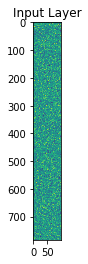

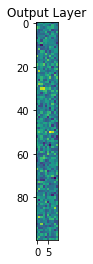

In [27]:
for l in m.layers:
    plt.imshow(l.weights)
    plt.title(l.name)
    plt.show()
    #plt.imshow(l.biases)
    #plt.title(l.name)
    #plt.show()

In [4]:
class Optimizer:
    def __init__(self, layers, name=None, learning_rate = 0.01, mr=0.001):
        self.name = name
        self.learning_rate = learning_rate
        self.mr = mr
        keys = ["sgd", "iterative", "momentum", "rmsprop", "adagrad", "adam", "adamax", "adadelta"]
        values = [self.sgd, self.iterative, self.momentum, self.rmsprop, self.adagrad, self.adam, self.adamax, self.adadelta]
        self.opt_dict = {keys[i]:values[i] for i in range(len(keys))}
        if name != None and name in keys:
            self.opt_dict[name](layers=layers, training=False)
            #pass
    def sgd(self, layers, learning_rate=0.01, beta=0.001, training=True):
        learning_rate = self.learning_rate
        for l in layers:
            if l.parameters !=0:
                if training:
                    l.weights += l.pdelta_weights*self.mr + l.delta_weights * learning_rate
                    l.biases += l.pdelta_biases*self.mr + l.delta_biases * learning_rate
                    l.pdelta_weights = l.delta_weights
                    l.pdelta_biases = l.delta_biases
    def iterative(self, layers, learning_rate=0.01, beta=0, training=True):
        for l in layers:
            if l.parameters !=0:
                l.weights -= learning_rate * l.delta_weights
                l.biases -= learning_rate * l.delta_biases
    def momentum(self, layers, learning_rate=0.1, beta1=0.9, weight_decay=0.0005, nesterov=True, training=True):
        learning_rate = self.learning_rate
        #beta1 = 1 - self.learning_rate
        for l in layers:
            if l.parameters !=0:
                if training:
                    l.weights_momentum = beta1 * l.weights_momentum + learning_rate * l.delta_weights-weight_decay *learning_rate*l.weights
                    l.weights+=l.weights_momentum
                    #
                    l.biases_momentum = beta1 * l.biases_momentum + learning_rate * l.delta_biases-weight_decay *learning_rate*l.biases
                    l.biases+=l.biases_momentum
                else:
                    l.weights_momentum = 0
                    l.biases_momentum = 0

            
    def rmsprop(self, layers, learning_rate=0.001, beta1=0.9, epsilon=1e-8, training=True):
        learning_rate=self.learning_rate
        for l in layers:
            if l.parameters !=0:
                if training:
                    l.weights_rms = beta1*l.weights_rms + (1-beta1)*(l.delta_weights ** 2)
                    l.weights += learning_rate * (l.delta_weights/np.sqrt(l.weights_rms + epsilon))
                    l.biases_rms = beta1*l.biases_rms + (1-beta1)*(l.delta_biases ** 2)
                    l.biases += learning_rate * (l.delta_biases/np.sqrt(l.biases_rms + epsilon))
                else:
                    l.weights_rms = 0
                    l.biases_rms = 0
    def adagrad(self, layers, learning_rate=0.01, beta1=0.9, epsilon=1e-8, training=True):
        learning_rate=self.learning_rate
        for l in layers:
            if l.parameters != 0:
                if training:
                    l.weights_adagrad += l.delta_weights ** 2
                    l.weights += learning_rate * (l.delta_weights/np.sqrt(l.weights_adagrad+epsilon))
                    l.biases_adagrad += l.delta_biases ** 2
                    l.biases += learning_rate * (l.delta_biases/np.sqrt(l.biases_adagrad+epsilon))
                else:
                    l.weights_adagrad = 0
                    l.biases_adagrad = 0
    def adam(self, layers, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, decay=0, training=True):
        #print(training)
        for l in layers:
            if l.parameters != 0:
                if training:
                    l.t += 1
                    if l.t == 1:
                        l.pdelta_biases = 0
                        l.pdelta_weights = 0
                    l.weights_adam1 = beta1 * l.weights_adam1 + (1-beta1)*l.delta_weights
                    l.weights_adam2 = beta2 * l.weights_adam2 + (1-beta2)*(l.delta_weights**2)
                    mcap = l.weights_adam1/(1-beta1**l.t)
                    vcap = l.weights_adam2/(1-beta2**l.t)
                    l.delta_weights = mcap/(np.sqrt(vcap) + epsilon)
                    l.weights += l.pdelta_weights * self.mr + learning_rate * l.delta_weights
                    l.pdelta_weights = l.delta_weights * 0

                    l.biases_adam1 = beta1 * l.biases_adam1 + (1-beta1)*l.delta_biases
                    l.biases_adam2 = beta2 * l.biases_adam2 + (1-beta2)*(l.delta_biases**2)
                    mcap = l.biases_adam1/(1-beta1**l.t)
                    vcap = l.biases_adam2/(1-beta2**l.t)
                    l.delta_biases = mcap/(np.sqrt(vcap) +epsilon)
                    l.biases += l.pdelta_biases * self.mr + learning_rate * l.delta_biases
                    l.pdelta_biases = l.delta_biases * 0
                    
                else:
                    l.t = 0
                    l.weights_adam1 = 0
                    l.weights_adam2 = 0
                    l.biases_adam1 = 0
                    l.biases_adam2 = 0
                    
    def adamax(self, layers, learning_rate=0.002, beta1=0.9, beta2=0.999, epsilon=1e-8, training=True):
        pass
    def adadelta(self, layers, learning_rate=0.01, beta1=0.9, epsilon=1e-8, training=True):
        pass

In [ ]:
data = pd.read_csv('ffndata.csv', header=None)
X = np.array(data[[0,1]])
y = np.array(data[2]).reshape(-1, 1) / 1.0
#print(X.shape, y.shape)
model = NN()
model.add(FFL(n_input=2, neurons=1, activation="sigmoid"))
# model.add(FFL(1, activation="sigmoid"))
model.compile_model(lr=0.01, opt="sgd", loss="cse", mr= 0.001)
model.summary()
model.train(X, y, epochs = 1000, batch_size=1, shuffle=False)

In [26]:
x = np.arange(0, 100).reshape(-1, 1)
x = x / x.max()
#y = np.repeat(np.array([[1, 0]]), 100, axis=0).reshape(100, 2)
#y = np.vstack([y, np.repeat(np.array([[0, 1]]), 100, axis=0).reshape(100, 2)])
y = x * 2 
#print(x.shape, y.shape)
mult = NN()
mult.add(FFL(1, 1))
#mult.add(FFL(neurons=10, activation="sigmoid"))
# mult.add(FFL(neurons=1))
mult.summary()

mult.compile_model(lr=0.01, opt="sgd", loss="mse", mr= 0.001)
mult.train(x, y, 10000,  show_every=1000, batch_size = 8, shuffle=True)

             Input  Neurons Activation  Bias
Layer Name                                  
Input Layer      1        1       None  True
Total Parameters:  2
None
Time: 0.017sec
Epoch: #0, Loss: 2.732500
Accuracy: 0.0%
None
Time: 5.355sec
Epoch: #1000, Loss: 0.000000
Accuracy: 1.0%
None
Time: 5.241sec
Epoch: #2000, Loss: 0.000000
Accuracy: 100.0%


KeyboardInterrupt: 

In [385]:
mult.predict([1000]), [l.weights for l in mult.layers]

([array([[2000.]])], [array([[2.]])])

In [ ]:
def golorot(shape):
    wts = np.random.randint(-6, 6, np.multiply.reduce(shape))/np.add.reduce(shape)
    return wts.reshape(shape)
golorot((5, 5, 3))    

In [ ]:
x.max()

In [ ]:
y.to_numpy()

In [ ]:
y_train